## Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from pytrends.request import TrendReq
import pytrends
from random import randint
import pmdarima as pm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

## Functions

In [6]:
def get_data(state, abb, kw_list):
    """takes state, state abbreviation from Google Trends 
    and keyword list as inputs and returns DataFrame
    containing ili rates for the state and Google Trends data
    for the keywords"""
    
     # ili data
    states_ili = pd.read_csv("ili_state_level.csv", header=0)
    states_ili["date"] = pd.to_datetime(states_ili.week.astype(str) + states_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    states_ili.set_index("date", inplace=True)
    ili = states_ili.loc[states_ili["region"]==state,:]
    ili = ili.shift(-1, freq='W')
    ili = ili.drop(["Unnamed: 0", "weighted_ili", "age_0_4", "age_25_49", "age_25_64", "age_5_24", "age_50_64", "age_65", "week_start"], axis=1)
    
     # Google Trends
    geo = "US-" + str(abb)
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo=geo)
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
    merged = merged.asfreq("W")
    
    return merged




def get_usdata(kw_list):
    """takes keyword list as input and returns DataFrame
    containing ili rates for the state and Google Trends 
    data for the keywords"""
    
    # ili data
    us_ili = pd.read_csv("ili_national_level.csv", header=0)
    us_ili["date"] = pd.to_datetime(us_ili.week.astype(str) + us_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    us_ili.set_index("date", inplace=True)
    ili = us_ili.shift(-1, freq='W')
       
    
    # Google Trends
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2015-01-11 2019-07-07", geo="US")
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
    merged["unweighted_ili"] = merged["unweighted_ili"].interpolate(method="linear")
    merged = merged.drop(merged.tail(4).index, inplace=False)
    merged = merged.asfreq("W")
    
    return merged




def correlation(df, kw):
    """takes dataframe and column name (i.e. a keyword) as input and returns
    the correlation between unweighted ili and the keyword search volume"""
    
    corr = df["unweighted_ili"].corr(df[kw])
    return corr
    
    
    
    
def corr_coefficients(state, abb, kw_list):
    """takes state , state abbreviation from Google Trends 
    and keyword list as inputs and returns correlation coefficients
    of ili rates and Google Trends keywords"""
    
    # ili data
    states_ili = pd.read_csv("ili_state_level.csv", header=0)
    states_ili["date"] = pd.to_datetime(states_ili.week.astype(str) + states_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    states_ili.set_index("date", inplace=True)
    ili = states_ili.loc[states_ili["region"]==state,:]
    ili = ili.shift(-1, freq='W')
    
    # Google Trends
    geo = "US-" + str(abb)
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo=geo)
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
        
    # correlation coefficients
    for var in kw_list:
        print("Corr. Coef. between unweighted_ili and " + var + " for " + str(state) + ": " + str(merged["unweighted_ili"].corr(merged[var])))

        
        
        
def add_weekdummies(df, drop_first=True):
    """takes a dataframe containing week variable as input and returns
    a dataframe containing the same data, but weeks coded as dummy variables"""
    df["week"] = df["week"].astype("category")
    new = pd.get_dummies(df, columns=["week"], drop_first=drop_first)
    
    return new




def ts_data(df):
    """takes ili dataframe as input and returns dataframe containing only 
    time series for unweighted_ili rates and google trends search volume"""
    
    clean = df.drop(['Unnamed: 0', 'region_type', 'region', 'year', 'week', 'weighted_ili', 'age_0_4', 'age_25_49', 'age_25_64', 'age_5_24', 'age_50_64', 'age_65', 'ilitotal', 'num_of_providers', 'total_patients', 'week_start'], axis=1)
    return clean




def lagged_ili(df, n=1):
    """takes dataframe with ili rates and google trends time series data as input and returns
    dataframe containing the same data, but unweighted_ili shifted n periods back"""
    
    df["unweighted_ili"].index = df["unweighted_ili"].index-n
    lagged = pd.concat([df.drop(columns=["unweighted_ili"]), df["unweighted_ili"]], axis=1)
    
    return lagged
    
    
    
    
def rmse(testdf, preddf):
    """takes two dataframes as input: testdf containing (true) test data 
    and preddf containing predictions made with a forecasting model;
    returns the root mean squared error as evaluation metric"""
    
    return np.sqrt(mean_squared_error(testdf, preddf))

## Exploration

In [13]:
# defining a keyword list to use for Google Trends
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]

In [14]:
ili_us = get_usdata(kw_list)
ili = ts_data(ili_us)

In [15]:
ili.corr()

,fever,flu,cough,sore throat,headache,unweighted_ili
fever,1.000000,0.761055,0.817418,0.750934,0.539895,0.918065
flu,0.761055,1.000000,0.693968,0.556131,0.502604,0.840000
cough,0.817418,0.693968,1.000000,0.876124,0.548691,0.851732
sore throat,0.750934,0.556131,0.876124,1.000000,0.546278,0.733684
headache,0.539895,0.502604,0.548691,0.546278,1.000000,0.466957
unweighted_ili,0.918065,0.840000,0.851732,0.733684,0.466957,1.000000


In [16]:
# correlation with lagged ili rates
lagged = lagged_ili(ili)
lagged.corr()

,fever,flu,cough,sore throat,headache,unweighted_ili
fever,1.000000,0.761055,0.817418,0.750934,0.539895,0.892788
flu,0.761055,1.000000,0.693968,0.556131,0.502604,0.840080
cough,0.817418,0.693968,1.000000,0.876124,0.548691,0.870640
sore throat,0.750934,0.556131,0.876124,1.000000,0.546278,0.728081
headache,0.539895,0.502604,0.548691,0.546278,1.000000,0.467050
unweighted_ili,0.892788,0.840080,0.870640,0.728081,0.467050,1.000000


## Forecasting

### Univariate Forecasting

In [17]:
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
ili_us = get_usdata(kw_list)
ili = ili_us["unweighted_ili"]

# defining train and test / forecasting data
train = ili.iloc[:179]
test = ili.iloc[179:]

#### SARIMA - using Auto Arima

In [18]:
# first test using Auto Arima
arima = pm.auto_arima(train, start_p=1, start_q=1, m=52, seasonal=True, trace=1, error_action="ignore")

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=622.949, BIC=629.323, Fit time=0.106 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=114.114, BIC=123.676, Fit time=0.106 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 52); AIC=35.574, BIC=48.323, Fit time=0.317 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 52); AIC=16.891, BIC=36.015, Fit time=0.452 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 52); AIC=23.240, BIC=39.177, Fit time=0.287 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 52); AIC=14.899, BIC=30.836, Fit time=0.248 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan second

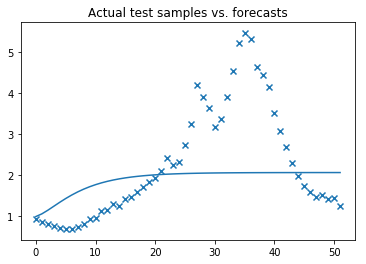

In [19]:
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

#### SARIMA more Data - time consuming

In [40]:
data = pd.read_csv("ili_national_more.csv", header=0)
data["date"] = pd.to_datetime(data.week.astype(str) + data.year.astype(str).add("-0"), format="%W%Y-%w")
data.set_index("date", inplace=True)
data = data.shift(-1, freq='W')
data = data.drop(['Unnamed: 0', 'region_type', 'region', 'year', 'week', 'weighted_ili',
       'age_0_4', 'age_25_49', 'age_25_64', 'age_5_24',
       'age_50_64', 'age_65', 'ilitotal', 'num_of_providers', 'total_patients',
       'week_start'], axis=1)
data = data.loc[~data.index.duplicated(keep='first')]
data = data.asfreq("W")

train2 = data.iloc[:772]
train2 = train2.fillna(method="ffill")
test2 = data.iloc[772:]
test2 = test2.fillna(method="ffill")

In [42]:
# first test using Auto Arima
arima = pm.auto_arima(train2, start_p=1, start_q=1, m=52, seasonal=True, trace=1, error_action="ignore")

C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 52); AIC=203.232, BIC=231.149, Fit time=75.321 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2391.911, BIC=2401.217, Fit time=0.052 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=421.672, BIC=440.283, Fit time=121.456 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=1442.175, BIC=1460.787, Fit time=18.940 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=247.988, BIC=271.252, Fit time=33.175 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 52); AIC=202.060, BIC=234.630, Fit time=337.462 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 0, 52); AIC=202.458, BIC=230.375, Fit time=1477.125 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 2, 52); AIC=294.877, BIC=332.100, Fit time=425.109 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 52); AIC=224.355, BIC=247.619, Fit time=147.046 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 1, 52); AIC=1279.231, BIC=1307.148, Fit time=333.255 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 0, 1, 52); AIC=154.112, BIC=191.335, Fit time=414.167 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 52); AIC=152.931, BIC=185.501, Fit time=350.363 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 1) seasonal_order=(2, 0, 1, 52); AIC=156.834, BIC=198.709, Fit time=497.628 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=153.048, BIC=180.965, Fit time=66.788 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 52); AIC=153.560, BIC=181.477, Fit time=1668.855 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 2, 52); AIC=243.070, BIC=280.293, Fit time=442.590 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=173.906, BIC=197.170, Fit time=154.737 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 52); AIC=375.050, BIC=402.967, Fit time=282.096 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 0) seasonal_order=(2, 0, 1, 52); AIC=154.287, BIC=191.510, Fit time=445.482 seconds
Total fit time: 7291.739 seconds


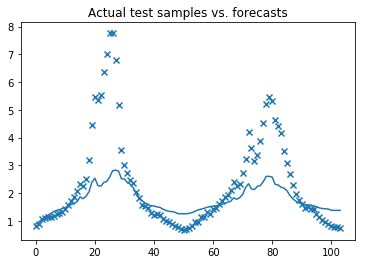

In [45]:
y = np.arange(test2.shape[0])
plt.scatter(y, test2, marker='x')
plt.plot(y, arima.predict(n_periods=test2.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

#### Holt Winters - Triple Exponential Smoothing

Helpful with regard to damped trend: https://otexts.com/fpp2/holt.html

In [20]:
# no damped trend
from statsmodels.tsa.holtwinters import ExponentialSmoothing
holt = ExponentialSmoothing(train, trend=None, seasonal="add", seasonal_periods=52)
holt_fit = holt.fit(optimized=True)
holt_pred = holt_fit.predict(start=test.index[0], end=test.index[-1])
# with damped trend
holt2 = ExponentialSmoothing(train, trend="add", damped=True, seasonal="add", seasonal_periods=52)
holt2_fit = holt2.fit(optimized=True)
holt2_pred = holt2_fit.predict(start=test.index[0], end=test.index[-1])

C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [21]:
rmse_holt = rmse(test, holt_pred)
rmse_holt2 = rmse(test, holt2_pred)

C:\Users\Tobi\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


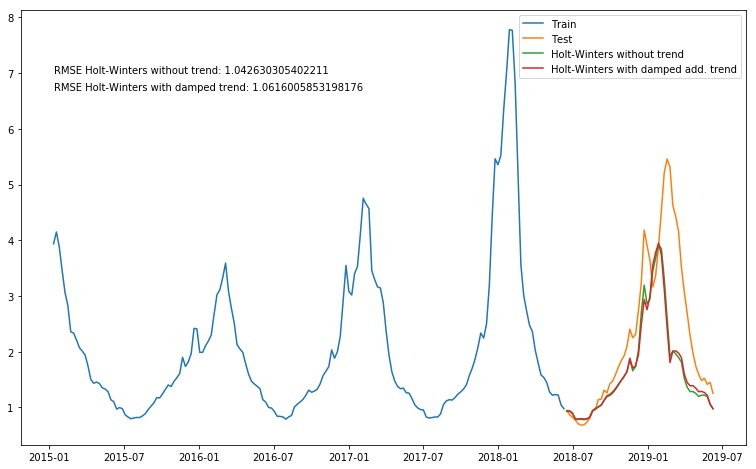

In [22]:
plt.figure(figsize=(13,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters without trend')
plt.plot(holt2_pred.index, holt2_pred, label='Holt-Winters with damped add. trend')
plt.text(train.index[0], 7, "RMSE Holt-Winters without trend: " + str(rmse_holt))
plt.text(train.index[0], 6.7, "RMSE Holt-Winters with damped trend: " + str(rmse_holt2))
plt.legend(loc='best')
plt.show()

#### Holt-Winters - Triple Exponential Smoothing with more data - time consuming

In [99]:
data = pd.read_csv("ili_national_more.csv", header=0)
data["date"] = pd.to_datetime(data.week.astype(str) + data.year.astype(str).add("-0"), format="%W%Y-%w")
data.set_index("date", inplace=True)
data = data.shift(-1, freq='W')
data = data.drop(['Unnamed: 0', 'region_type', 'region', 'year', 'week', 'weighted_ili',
       'age_0_4', 'age_25_49', 'age_25_64', 'age_5_24',
       'age_50_64', 'age_65', 'ilitotal', 'num_of_providers', 'total_patients',
       'week_start'], axis=1)
data = data.loc[~data.index.duplicated(keep='first')]
data = data.asfreq("W")

train2 = data.iloc[:772]
train2 = train2.fillna(method="ffill")
test2 = data.iloc[772:]
test2 = test2.fillna(method="ffill")

In [102]:
# no damped trend
from statsmodels.tsa.holtwinters import ExponentialSmoothing
more_holt = ExponentialSmoothing(train2, trend=None, seasonal="add", seasonal_periods=52)
more_holt_fit = more_holt.fit(optimized=True)
more_holt_pred = more_holt_fit.predict(start=test2.index[0], end=test2.index[-1])
# with damped trend
more_holt2 = ExponentialSmoothing(train2, trend="add", damped=True, seasonal="add", seasonal_periods=52)
more_holt2_fit = more_holt2.fit(optimized=True)
more_holt2_pred = more_holt2_fit.predict(start=test2.index[0], end=test2.index[-1])

In [103]:
rmse_more_holt = rmse(test2, more_holt_pred)
rmse_more_holt2 = rmse(test2, more_holt2_pred)

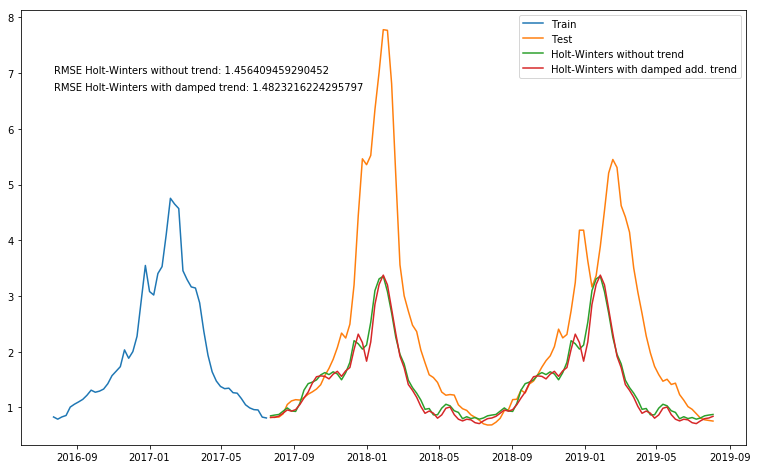

In [107]:
plt.figure(figsize=(13,8))
plt.plot(train2.index[720:], train2[720:], label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(more_holt_pred.index, more_holt_pred, label='Holt-Winters without trend')
plt.plot(more_holt2_pred.index, more_holt2_pred, label='Holt-Winters with damped add. trend')
plt.text(train2.index[720], 7, "RMSE Holt-Winters without trend: " + str(rmse_more_holt))
plt.text(train2.index[720], 6.7, "RMSE Holt-Winters with damped trend: " + str(rmse_more_holt2))
plt.legend(loc='best')
plt.show()

#### Rolling Window Regression

#### Facebook Prophet

In [1]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [68]:
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
ili_aux = get_usdata(kw_list)
ili_2 = ts_data(ili_aux)
ili = ili_2.drop(kw_list, axis=1)
ili["ds"] = ili.index
ili["y"] = ili.unweighted_ili
ili.reset_index(inplace=True)
ili = ili.drop(["date", "unweighted_ili"], axis=1)
train = ili.loc[:178]
test = ili.loc[179:]

In [51]:
model = Prophet()
model.fit(ili)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
591,2020-06-04
592,2020-06-05
593,2020-06-06
594,2020-06-07
595,2020-06-08


In [53]:
forecast = model.predict(future)

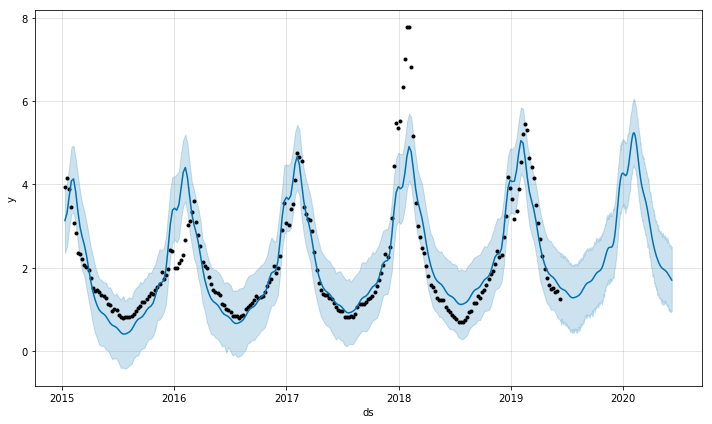

In [54]:
plot = model.plot(forecast)
#plot_components = model.plot_components(forecast)

In [79]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='1197 days', period="180 days", horizon="365 days")

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-06-09 00:00:00 and 2018-06-09 00:00:00


In [81]:
from fbprophet.diagnostics import performance_metrics
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-06-10,1.710237,0.824755,2.575223,0.978113,2018-06-09
1,2018-06-17,1.714158,0.849502,2.540611,0.947548,2018-06-09
2,2018-06-24,1.695146,0.874200,2.517445,0.867554,2018-06-09
3,2018-07-01,1.636781,0.845731,2.490603,0.823280,2018-06-09
4,2018-07-08,1.564633,0.715748,2.351110,0.771497,2018-06-09


In [116]:
pred = df_cv["yhat"].iloc[1:]
date = df_cv["ds"].iloc[1:]
actual = df_cv["y"].iloc[1:]
frame = {"date": date, "yhat": pred, "actual": actual}

In [117]:
predictions = pd.DataFrame(frame)

In [118]:
predictions.head()

,date,yhat,actual
1,2018-06-17,1.714158,0.947548
2,2018-06-24,1.695146,0.867554
3,2018-07-01,1.636781,0.823280
4,2018-07-08,1.564633,0.771497
5,2018-07-15,1.519090,0.706819


In [122]:
y_pred = predictions.yhat
y_actual = predictions.actual
fb_rmse = rmse(y_actual, y_pred)

In [127]:
train.head()

,ds,y
0,2015-01-11,3.93762
1,2015-01-18,4.15076
2,2015-01-25,3.87899
3,2015-02-01,3.45794
4,2015-02-08,3.06359


In [132]:
train.ds

0     2015-01-11
1     2015-01-18
2     2015-01-25
3     2015-02-01
4     2015-02-08
5     2015-02-15
6     2015-02-22
7     2015-03-01
8     2015-03-08
9     2015-03-15
10    2015-03-22
11    2015-03-29
12    2015-04-05
13    2015-04-12
14    2015-04-19
15    2015-04-26
16    2015-05-03
17    2015-05-10
18    2015-05-17
19    2015-05-24
20    2015-05-31
21    2015-06-07
22    2015-06-14
23    2015-06-21
24    2015-06-28
25    2015-07-05
26    2015-07-12
27    2015-07-19
28    2015-07-26
29    2015-08-02
         ...    
149   2017-11-19
150   2017-11-26
151   2017-12-03
152   2017-12-10
153   2017-12-17
154   2017-12-24
155   2017-12-31
156   2018-01-07
157   2018-01-14
158   2018-01-21
159   2018-01-28
160   2018-02-04
161   2018-02-11
162   2018-02-18
163   2018-02-25
164   2018-03-04
165   2018-03-11
166   2018-03-18
167   2018-03-25
168   2018-04-01
169   2018-04-08
170   2018-04-15
171   2018-04-22
172   2018-04-29
173   2018-05-06
174   2018-05-13
175   2018-05-20
176   2018-05-

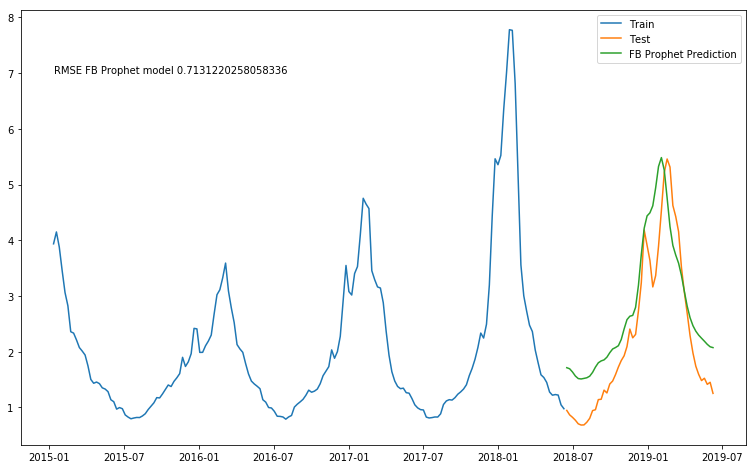

In [140]:
plt.figure(figsize=(13,8))
plt.plot(train.ds, train.y, label='Train')
plt.plot(test.ds, test.y, label='Test')
plt.plot(test.ds, y_pred, label='FB Prophet Prediction')
plt.text(train.ds[0], 7, "RMSE FB Prophet model " + str(fb_rmse))
plt.legend(loc='best')
plt.show()